In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NAN

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [5]:
df_numeric = df[['Age', 'SibSp', 'Parch', 'Fare']]
df_categoricals = df[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]
df.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

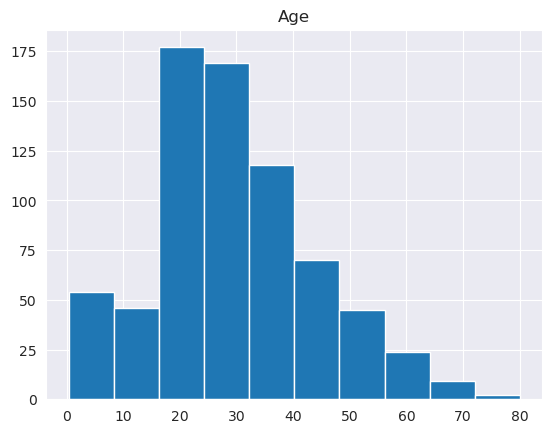

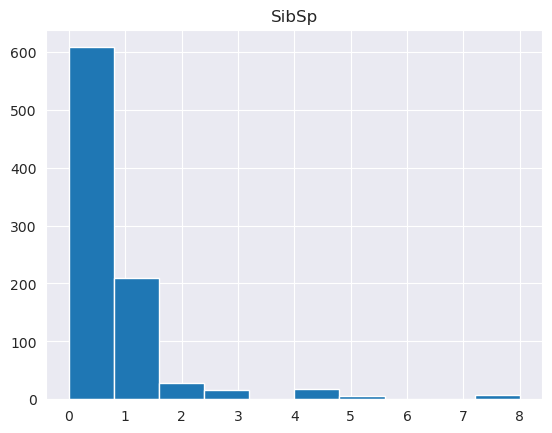

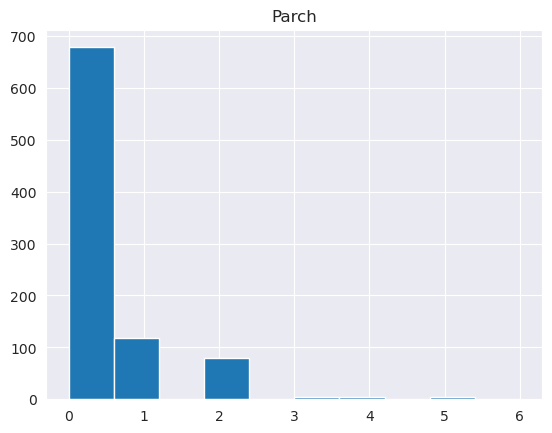

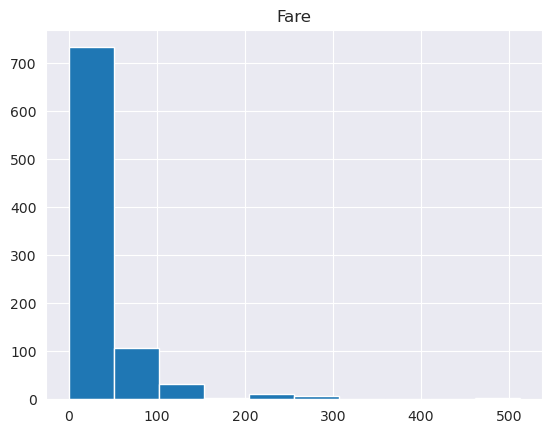

In [6]:
for column in df_numeric:
    plt.hist(df_numeric[column])
    plt.title(column)
    plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<Axes: >

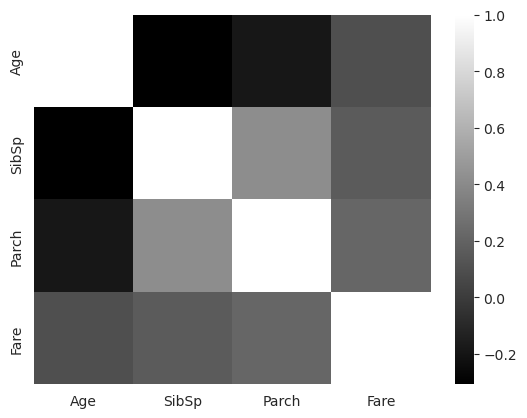

In [7]:
print(df_numeric.corr())
sns.heatmap(df_numeric.corr(), cmap='gray')

In [8]:
pd.pivot_table(df, index='Survived', values=['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


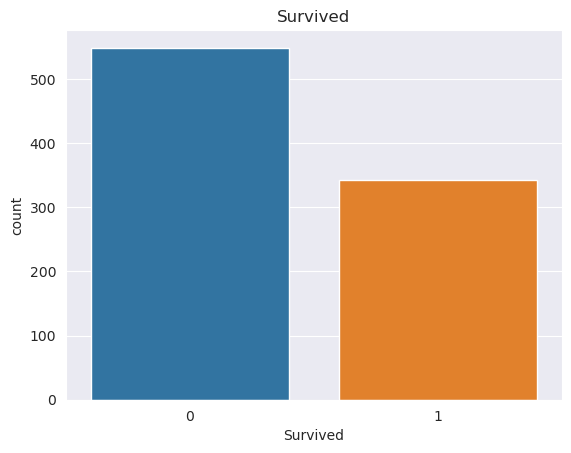

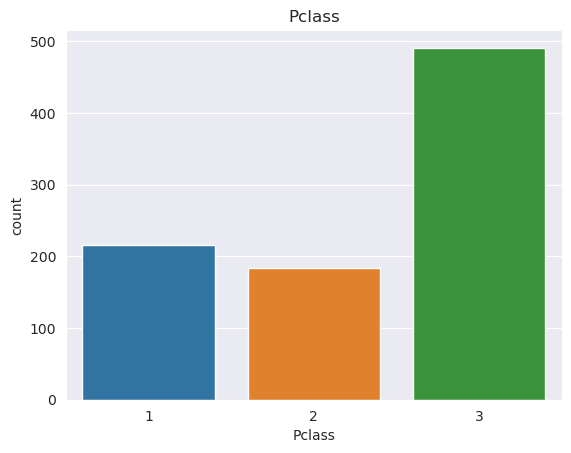

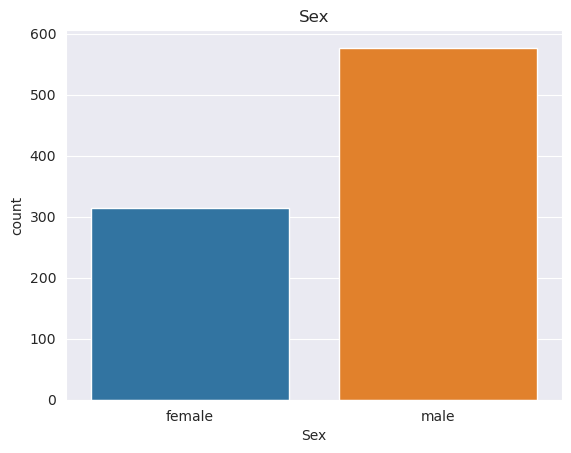

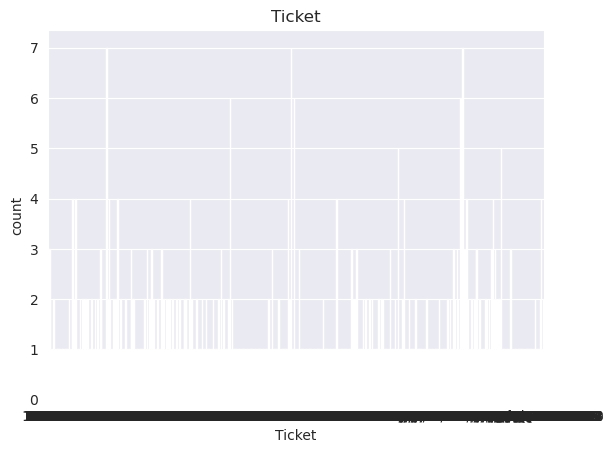

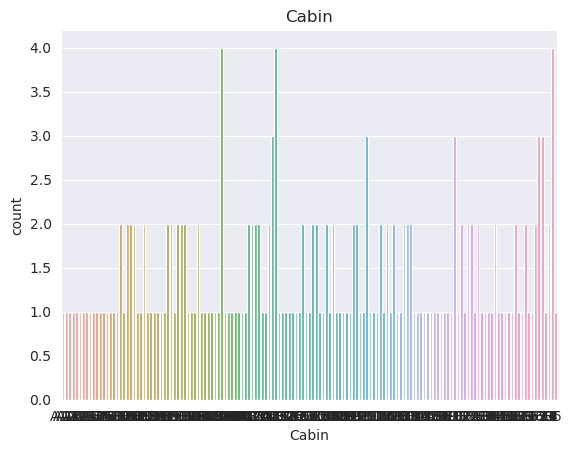

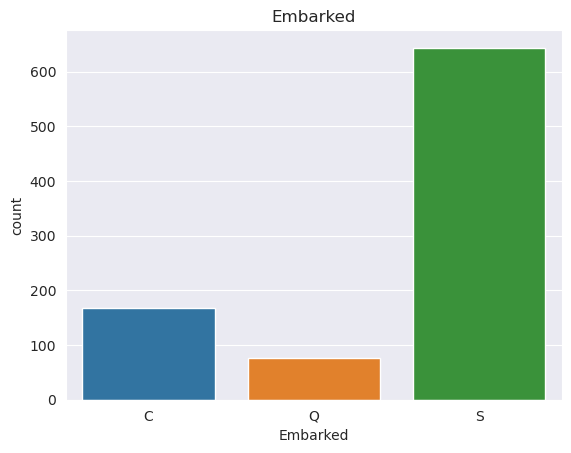

In [9]:
for column in df_categoricals.columns:
    value_counts = df_categoricals[column].value_counts().sort_index()
    sns.barplot(x=value_counts.index, y=value_counts)
    plt.title(column)
    plt.show()

In [10]:
print(pd.pivot_table(df, index='Survived', columns='Pclass', values='Ticket', aggfunc='count'))
print(pd.pivot_table(df, index='Survived', columns='Sex', values='Ticket', aggfunc='count'))
print(pd.pivot_table(df, index='Survived', columns='Embarked', values='Ticket', aggfunc='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
Sex       female  male
Survived              
0             81   468
1            233   109
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


In [11]:
df['cabin_multiple'] = df.Cabin.apply(lambda x : 0 if pd.isna(x) else len(x.split(' ')))
df['cabin_multiple'].value_counts()

cabin_multiple
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

In [12]:
pd.pivot_table(df, index='Survived', columns='cabin_multiple', values='Ticket', aggfunc='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [13]:
df['cabin_adv'] = df.Cabin.apply(lambda x: str(x)[0])
print(df.cabin_adv.value_counts())
pd.pivot_table(df, index='Survived', columns='cabin_adv', values='Name', aggfunc='count')

cabin_adv
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


In [14]:
df['numeric_ticket'] = df.Ticket.apply(lambda x : 1 if x.isnumeric() else 0)
df['ticket_letters'] = df.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.', '').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)
print(df.numeric_ticket.value_counts())
# pd.set_option("max_rows", None)
df.ticket_letters.value_counts()

numeric_ticket
1    661
0    230
Name: count, dtype: int64


ticket_letters
0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
sopp           3
pp             3
wep            3
ppp            2
scah           2
sotono2        2
swpp           2
fc             1
scahbasle      1
as             1
sp             1
sc             1
scow           1
fa             1
sop            1
sca4           1
casoton        1
Name: count, dtype: int64

In [15]:
pd.pivot_table(df, index='Survived', columns='numeric_ticket', values='Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [16]:
pd.pivot_table(df, index='Survived', columns='ticket_letters', values='Ticket', aggfunc='count')

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


In [17]:
df.Name.head()
df['name_title'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['name_title'].value_counts()

name_title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [18]:
pd.pivot_table(df, index='Survived', columns='name_title', values='Ticket', aggfunc='count')

name_title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,4.0,1.0,NaN,1.0,17.0,55.0,NaN,NaN,436.0,26.0,NaN,6.0,NaN,NaN
1,NaN,1.0,NaN,3.0,NaN,1.0,1.0,23.0,127.0,2.0,1.0,81.0,99.0,1.0,NaN,1.0,1.0


In [19]:
all_data = pd.concat([df, test])

In [20]:
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = df.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = df.Ticket.apply(lambda x : 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = df.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.', '').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)
all_data['name_title'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

all_data.Age = all_data.Age.fillna(df.Age.mean())
all_data.Fare = all_data.Fare.fillna(df.Fare.mean())
all_data.dropna(subset=['Embarked'], inplace=True)

<Axes: >

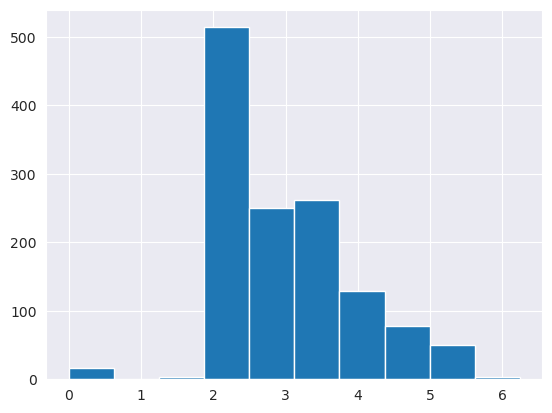

In [21]:
all_data['norm_fare'] = np.log(all_data.Fare + 1)
all_data['norm_fare'].hist()

In [22]:
all_data.Pclass = all_data.Pclass.astype(str)
all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title', 'train_test']])
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis=1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis=1)
y_train = all_data[all_data.train_test == 1].Survived
y_train.shape

(889,)

In [23]:
scaler = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']] = scaler.fit_transform(all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']])
X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis=1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis=1)
y_train = all_data[all_data.train_test == 1].Survived

In [24]:
# Naive Bayes
bayes_clf = GaussianNB()
cross_val = cross_val_score(bayes_clf, X_train_scaled, y_train, cv=5)
print(cross_val.mean())

0.7221735542436362


In [25]:
# Logistic Regression
lr_clf = LogisticRegression()
cross_val = cross_val_score(lr_clf, X_train_scaled, y_train, cv=5)
print(cross_val.mean())

0.8211832666793626


In [26]:
# Tree
tree_clf = tree.DecisionTreeClassifier(max_depth=4)
cross_val = cross_val_score(tree_clf, X_train_scaled, y_train, cv=5)
print(cross_val.mean())

0.8234368056878056


In [27]:
# SVM
svm_clf = SVC(C=1)
cross_val = cross_val_score(svm_clf, X_train_scaled, y_train, cv=5)
print(cross_val.mean())

0.8324319177299563


In [28]:
# kNN
knn_clf = KNeighborsClassifier(n_neighbors=10)
cross_val = cross_val_score(knn_clf, X_train_scaled, y_train, cv=5)
print(cross_val.mean())

0.8324192217355424


In [29]:
# Random Forest
forest_clf = RandomForestClassifier(n_estimators=9, n_jobs=-1)
cross_val = cross_val_score(forest_clf, X_train_scaled, y_train, cv=5)
print(cross_val.mean())

0.7964451215641464


In [30]:
# Voting Classifier
voting_clf = VotingClassifier(estimators=[('forest_clf', forest_clf), ('svm_clf', svm_clf), ('bayes_clf', bayes_clf), ('knn_clf', knn_clf), ('tree_clf', tree_clf), ('lr_clf', lr_clf)], voting='hard')
cross_val = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5)
print(cross_val.mean())

0.8301910747159271


In [31]:
bayes_clf.fit(X_train_scaled, y_train)
lr_clf.fit(X_train_scaled, y_train)
knn_clf.fit(X_train_scaled, y_train)
tree_clf.fit(X_train_scaled, y_train)
forest_clf.fit(X_train_scaled, y_train)
svm_clf.fit(X_train_scaled, y_train)
voting_clf.fit(X_train_scaled, y_train)

bayes_predict = bayes_clf.predict(X_test_scaled)
lr_predict = lr_clf.predict(X_test_scaled)
knn_predict = knn_clf.predict(X_test_scaled)
tree_predict = tree_clf.predict(X_test_scaled)
forest_predict = forest_clf.predict(X_test_scaled)
svm_predict = svm_clf.predict(X_test_scaled)
voting_predict = voting_clf.predict(X_test_scaled)

In [32]:
final_data = {'PassengerId': test.PassengerId, 'Survived': bayes_predict}
submission_bayes = pd.DataFrame(data=final_data)

final_data = {'PassengerId': test.PassengerId, 'Survived': lr_predict}
submission_lr = pd.DataFrame(data=final_data)

final_data = {'PassengerId': test.PassengerId, 'Survived': knn_predict}
submission_knn = pd.DataFrame(data=final_data)

final_data = {'PassengerId': test.PassengerId, 'Survived': tree_predict}
submission_tree = pd.DataFrame(data=final_data)

final_data = {'PassengerId': test.PassengerId, 'Survived': forest_predict}
submission_forest = pd.DataFrame(data=final_data)

final_data = {'PassengerId': test.PassengerId, 'Survived': svm_predict}
submission_svm = pd.DataFrame(data=final_data)

final_data = {'PassengerId': test.PassengerId, 'Survived': voting_predict}
submission_voting = pd.DataFrame(data=final_data)

In [33]:
for submission in [submission_bayes, submission_lr, submission_knn, submission_tree, submission_forest, submission_svm, submission_voting]:
    submission.Survived = submission.Survived.astype(int)

In [34]:
submission_bayes.to_csv('submission_bayes.csv', index=False)
submission_lr.to_csv('submission_lr.csv', index=False)
submission_knn.to_csv('submission_knn.csv', index=False)
submission_tree.to_csv('submission_tree.csv', index=False)
submission_forest.to_csv('submission_forest.csv', index=False)
submission_svm.to_csv('submission_svm.csv', index=False)
submission_voting.to_csv('submission_voting.csv', index=False)